In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer

In [2]:
def create_pie_chart(data, column):
    # Calculate the percentage of each category
    category_counts = data[column].value_counts()
    categories = category_counts.index
    counts = category_counts.values

    # Create the pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=categories, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("husl", len(categories)))
    plt.title(f'Distribution of {column}')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()

In [3]:
def generate_report(dataset : pd.DataFrame, basic_type : dict):
    for_numerical = dataset.select_dtypes(include='number').describe().T
    for_categorical = dataset.select_dtypes(include='object').describe().T

    for_numerical["NaNs"] = dataset.select_dtypes(include='number').isnull().sum()
    for_numerical["NaN_per"] = (dataset.select_dtypes(include='number').isnull().sum() / dataset.shape[0]) * 100
    for_numerical["Uniques"] = dataset.select_dtypes(include='number').nunique()
    for_numerical["Unique_per"] = (dataset.select_dtypes(include='number').nunique() / dataset.shape[0]) * 100

    for cols in for_numerical.index:
        for_numerical.at[cols, "BaseType"] = basic_type[cols]

    return (for_numerical, for_categorical)

In [41]:
def get_type_of_each_row(dataframe : pd.DataFrame):
    datatypes = {}
    for column in dataframe.columns:
        sub_values = []
        for values in dataframe[column]:
            sub_values.append(str(type(values)))
        datatypes[column] = max(sub_values)
        sub_values.clear()
    return datatypes

In [45]:
def identify_outliers(dataframe : pd.DataFrame):
    total_outliers = {}
    for cols in dataframe.select_dtypes(include='number').columns:
        Q1 = dataframe[cols].quantile(0.25)
        Q3 = dataframe[cols].quantile(0.75)
        
        IQR = Q3 - Q1
        
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR

        total_outliers[cols] = f"Below lower limit(${lower_limit}) total '{dataframe[dataframe[cols] < lower_limit].shape[0]}' values, Above higher limit({upper_limit}) total '{dataframe[dataframe[cols] > upper_limit].shape[0]}' values"
    return total_outliers

In [46]:
def remove_outliers(dataframe : pd.DataFrame, target_columns : list) -> pd.DataFrame:
    temp = dataframe.copy()
    for cols in target_columns:
        Q1 = temp[cols].quantile(0.25)
        Q3 = temp[cols].quantile(0.75)
        
        IQR = Q3 - Q1
        
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR

        temp[cols] = np.where(
            temp[cols] < lower_limit, 
            lower_limit,
            np.where(
                temp[cols] > upper_limit, 
                upper_limit,
                temp[cols]
            )
        )
    return temp

In [71]:
dataset = pd.read_csv("D:\\Machine_Learning\\codes\\Own_model\\data_csv\\gym_members_exercise_tracking.csv")

In [42]:
report_numerical, report_categorical = generate_report(dataset, get_type_of_each_row(dataset))

In [43]:
report_numerical

count        mean         std     min     25%  \
Age                            973.0   38.683453   12.180928   18.00   28.00   
Weight (kg)                    973.0   73.846197   21.185608   40.00   58.10   
Height (m)                     973.0    1.722580    0.127720    1.50    1.62   
Max_BPM                        973.0  179.883864   11.525686  160.00  170.00   
Avg_BPM                        973.0  143.766701   14.345101  120.00  131.00   
Resting_BPM                    973.0   62.223022    7.327060   50.00   56.00   
Session_Duration (hours)       973.0    1.256423    0.343033    0.50    1.04   
Calories_Burned                973.0  904.636177  270.430869  303.00  720.00   
Fat_Percentage                 973.0   24.976773    6.259419   10.00   21.30   
Water_Intake (liters)          973.0    2.626619    0.600172    1.50    2.20   
Workout_Frequency (days/week)  973.0    3.321686    0.913047    2.00    3.00   
Experience_Level               973.0    1.809866    0.739693    1.00    1.00   
BMI                            973.0   24.825391    6.411395   12.32   20.11   

                                  50%      75%       max  NaNs  NaN_per  \
Age                             40.00    49.00    59.000     0      0.0   
Weight (kg)                     70.00    86.00   127.850     0      0.0   
Height (m)                       1.71     1.80     2.000     0      0.0   
Max_BPM                        180.00   190.00   199.000     0      0.0   
Avg_BPM                        143.00   156.00   169.000     0      0.0   
Resting_BPM                     62.00    68.00    74.000     0      0.0   
Session_Duration (hours)         1.26     1.46     2.000     0      0.0   
Calories_Burned                893.00  1076.00  1610.000     0      0.0   
Fat_Percentage                  26.20    29.30    35.000     0      0.0   
Water_Intake (liters)            2.60     3.10     3.700     0      0.0   
Workout_Frequency (days/week)    3.00     4.00     5.000     0      0.0   
Experience_Level                 2.00     2.00     3.000     0      0.0   
BMI                             24.16    28.56    41.235     0      0.0   

                               Uniques  Unique_per         BaseType  
Age                                 42    4.316547  <class 'float'>  
Weight (kg)                        526   54.059609  <class 'float'>  
Height (m)                          51    5.241521  <class 'float'>  
Max_BPM                             40    4.110997  <class 'float'>  
Avg_BPM                             50    5.138746  <class 'float'>  
Resting_BPM                         25    2.569373  <class 'float'>  
Session_Duration (hours)           147   15.107914  <class 'float'>  
Calories_Burned                    612   62.898253  <class 'float'>  
Fat_Percentage                     239   24.563207  <class 'float'>  
Water_Intake (liters)               23    2.363823  <class 'float'>  
Workout_Frequency (days/week)        4    0.411100  <class 'float'>  
Experience_Level                     3    0.308325  <class 'float'>  
BMI                                750   77.081192  <class 'float'>

In [44]:
report_categorical

count unique       top freq
Gender         973      2      Male  511
Workout_Type   973      4  Strength  258

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            973 non-null    int64  
 1   Gender                         973 non-null    object 
 2   Weight (kg)                    973 non-null    float64
 3   Height (m)                     973 non-null    float64
 4   Max_BPM                        973 non-null    int64  
 5   Avg_BPM                        973 non-null    int64  
 6   Resting_BPM                    973 non-null    int64  
 7   Session_Duration (hours)       973 non-null    float64
 8   Calories_Burned                973 non-null    float64
 9   Workout_Type                   973 non-null    object 
 10  Fat_Percentage                 973 non-null    float64
 11  Water_Intake (liters)          973 non-null    float64
 12  Workout_Frequency (days/week)  973 non-null    int

In [6]:
def remove_outliers(dataframe : pd.DataFrame, target_columns : list) -> pd.DataFrame:
    temp = dataframe.copy()
    for cols in target_columns:
        Q1 = temp[cols].quantile(0.25)
        Q3 = temp[cols].quantile(0.75)
        
        IQR = Q3 - Q1
        
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR

        temp[cols] = np.where(
            temp[cols] < lower_limit, 
            lower_limit,
            np.where(
                temp[cols] > upper_limit, 
                upper_limit,
                temp[cols]
            )
        )
    return temp

In [7]:
dataset.describe()

Age  Weight (kg)  Height (m)     Max_BPM     Avg_BPM  \
count  973.000000   973.000000   973.00000  973.000000  973.000000   
mean    38.683453    73.854676     1.72258  179.883864  143.766701   
std     12.180928    21.207500     0.12772   11.525686   14.345101   
min     18.000000    40.000000     1.50000  160.000000  120.000000   
25%     28.000000    58.100000     1.62000  170.000000  131.000000   
50%     40.000000    70.000000     1.71000  180.000000  143.000000   
75%     49.000000    86.000000     1.80000  190.000000  156.000000   
max     59.000000   129.900000     2.00000  199.000000  169.000000   

       Resting_BPM  Session_Duration (hours)  Calories_Burned  Fat_Percentage  \
count   973.000000                973.000000       973.000000      973.000000   
mean     62.223022                  1.256423       905.422405       24.976773   
std       7.327060                  0.343033       272.641516        6.259419   
min      50.000000                  0.500000       303.000000       10.000000   
25%      56.000000                  1.040000       720.000000       21.300000   
50%      62.000000                  1.260000       893.000000       26.200000   
75%      68.000000                  1.460000      1076.000000       29.300000   
max      74.000000                  2.000000      1783.000000       35.000000   

       Water_Intake (liters)  Workout_Frequency (days/week)  Experience_Level  \
count             973.000000                     973.000000        973.000000   
mean                2.626619                       3.321686          1.809866   
std                 0.600172                       0.913047          0.739693   
min                 1.500000                       2.000000          1.000000   
25%                 2.200000                       3.000000          1.000000   
50%                 2.600000                       3.000000          2.000000   
75%                 3.100000                       4.000000          2.000000   
max                 3.700000                       5.000000          3.000000   

              BMI  
count  973.000000  
mean    24.912127  
std      6.660879  
min     12.320000  
25%     20.110000  
50%     24.160000  
75%     28.560000  
max     49.840000

In [8]:
numerical_cols = dataset.select_dtypes(include='number').columns

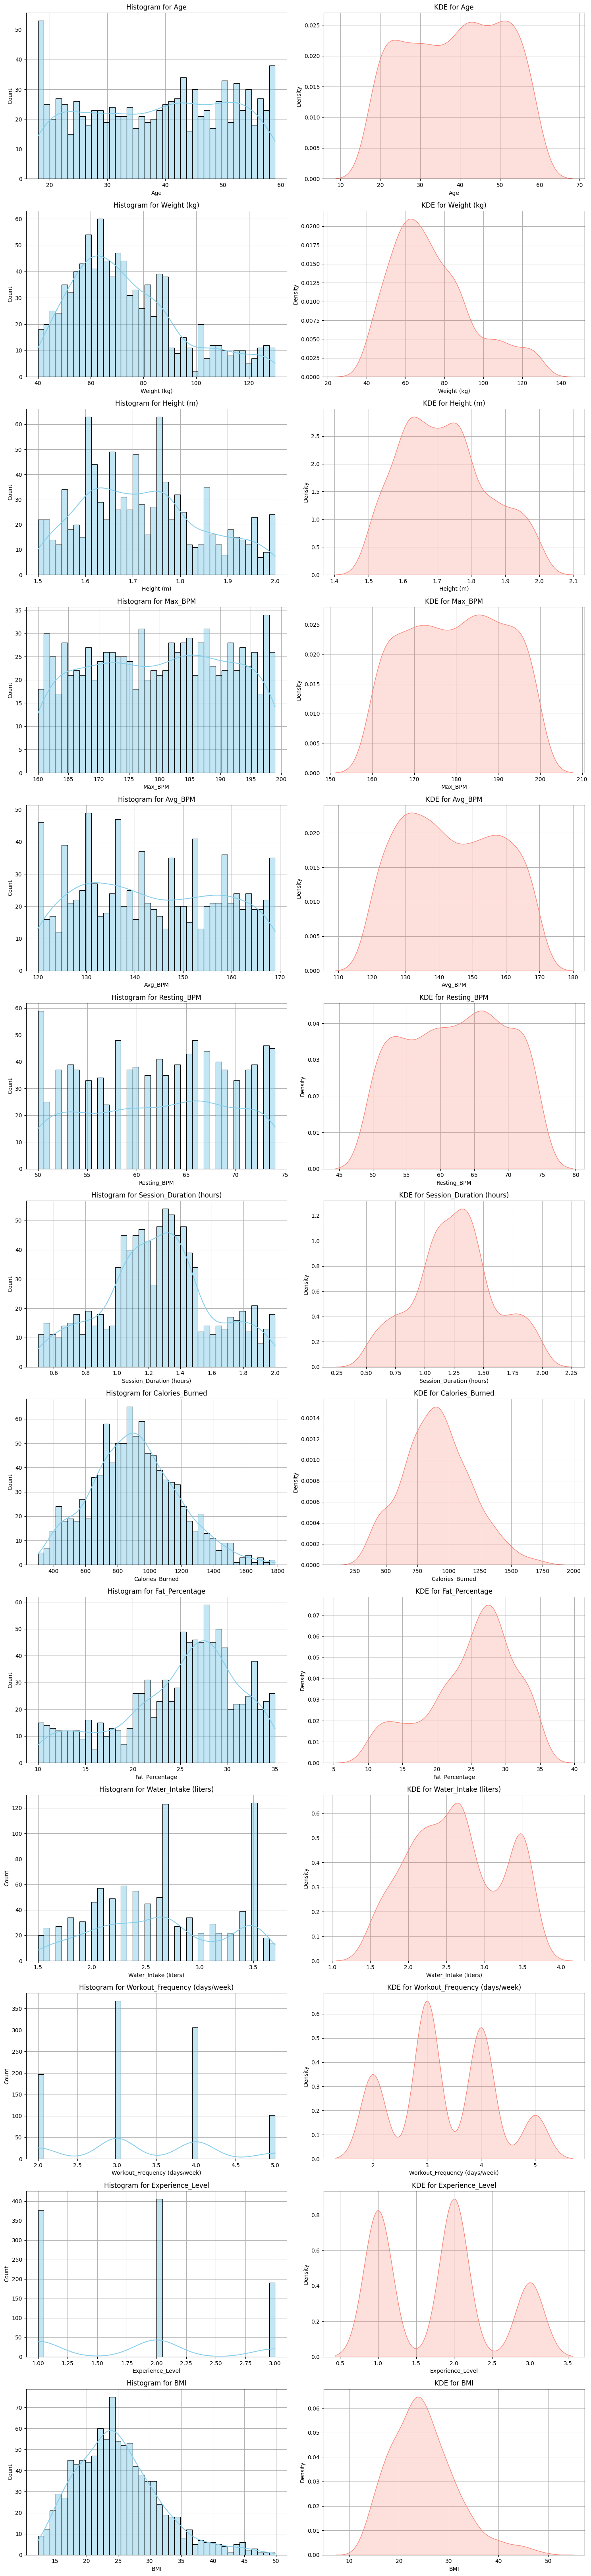

In [9]:
# Set the figure size
fig, axes = plt.subplots(len(numerical_cols), 2, figsize=(15, 5 * len(numerical_cols)))

for i, col in enumerate(numerical_cols):
    sns.histplot(dataset[col], kde=True, ax=axes[i, 0], color='skyblue', bins=40)
    axes[i, 0].set_title(f"Histogram for {col}")
    axes[i, 0].grid(True)
    axes[i, 0].set_axisbelow(True)
    
    sns.kdeplot(dataset[col], ax=axes[i, 1], fill=True, color='salmon')
    axes[i, 1].set_title(f"KDE for {col}")
    axes[i, 1].grid(True)
    axes[i, 1].set_axisbelow(True)
plt.tight_layout()
plt.show()

C:\Users\Parth Kachhadiya\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


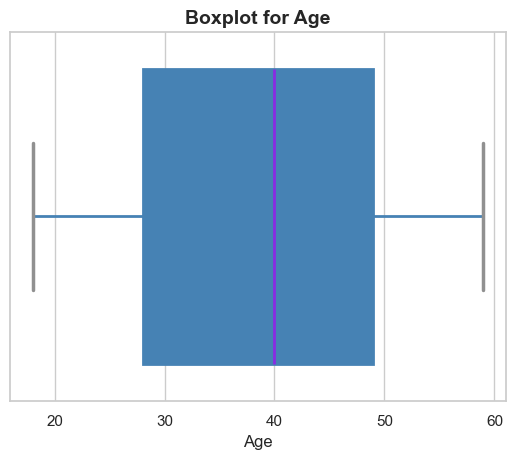

C:\Users\Parth Kachhadiya\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


C:\Users\Parth Kachhadiya\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


C:\Users\Parth Kachhadiya\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


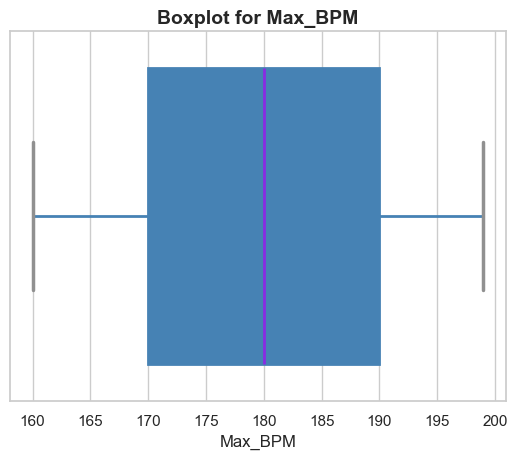

C:\Users\Parth Kachhadiya\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


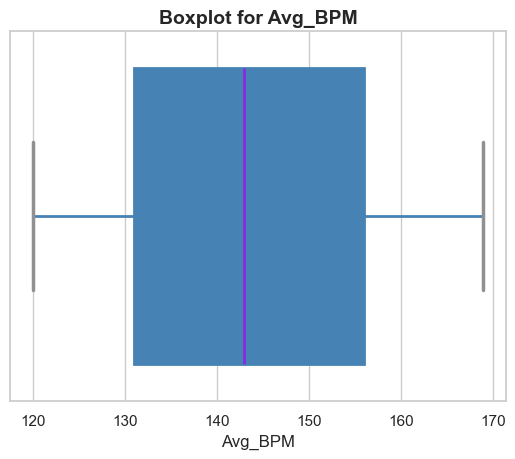

C:\Users\Parth Kachhadiya\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


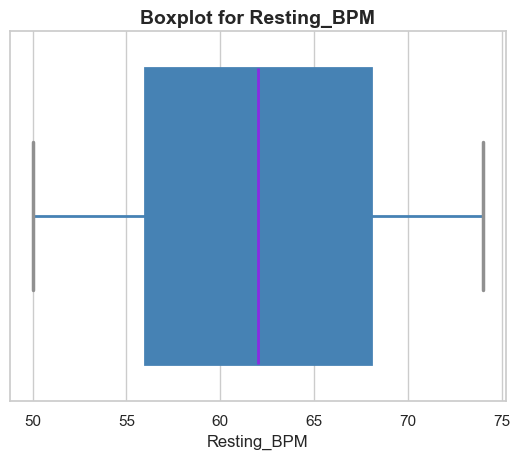

C:\Users\Parth Kachhadiya\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


C:\Users\Parth Kachhadiya\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


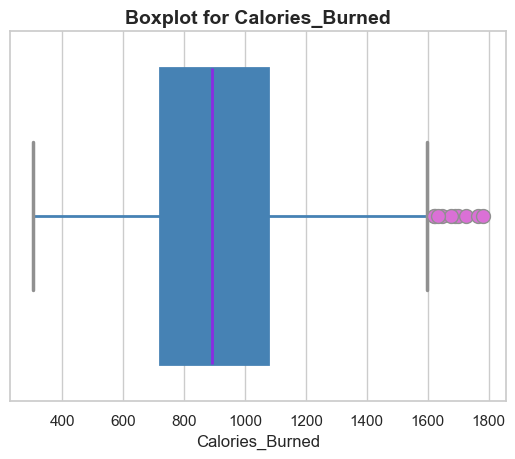

C:\Users\Parth Kachhadiya\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


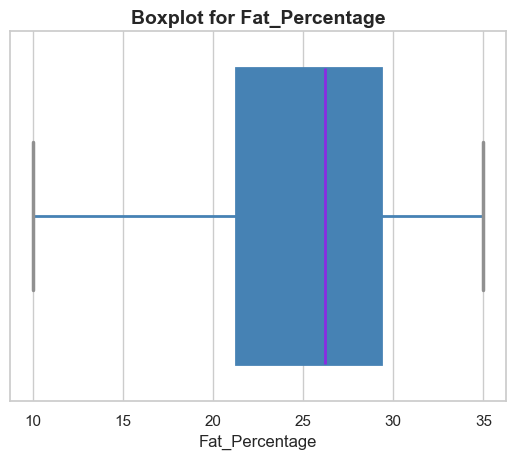

C:\Users\Parth Kachhadiya\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


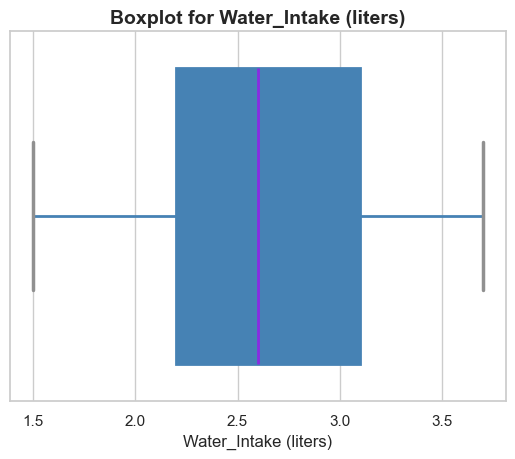

C:\Users\Parth Kachhadiya\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


C:\Users\Parth Kachhadiya\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


C:\Users\Parth Kachhadiya\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


In [72]:
for cols in dataset.select_dtypes(include='number').columns:
    sns.boxplot(dataset, x=cols, color='lightcyan', linewidth=2.5, fliersize=8,
                whiskerprops=dict(color='steelblue', linewidth=2),
                boxprops=dict(facecolor='aliceblue', color='steelblue', linewidth=2),
                medianprops=dict(color='blueviolet', linewidth=2),
                flierprops=dict(marker='o', markerfacecolor='orchid', markersize=10, linestyle='none'))
    plt.title(f"Boxplot for {cols}", fontsize=14, weight='bold')
    plt.show()

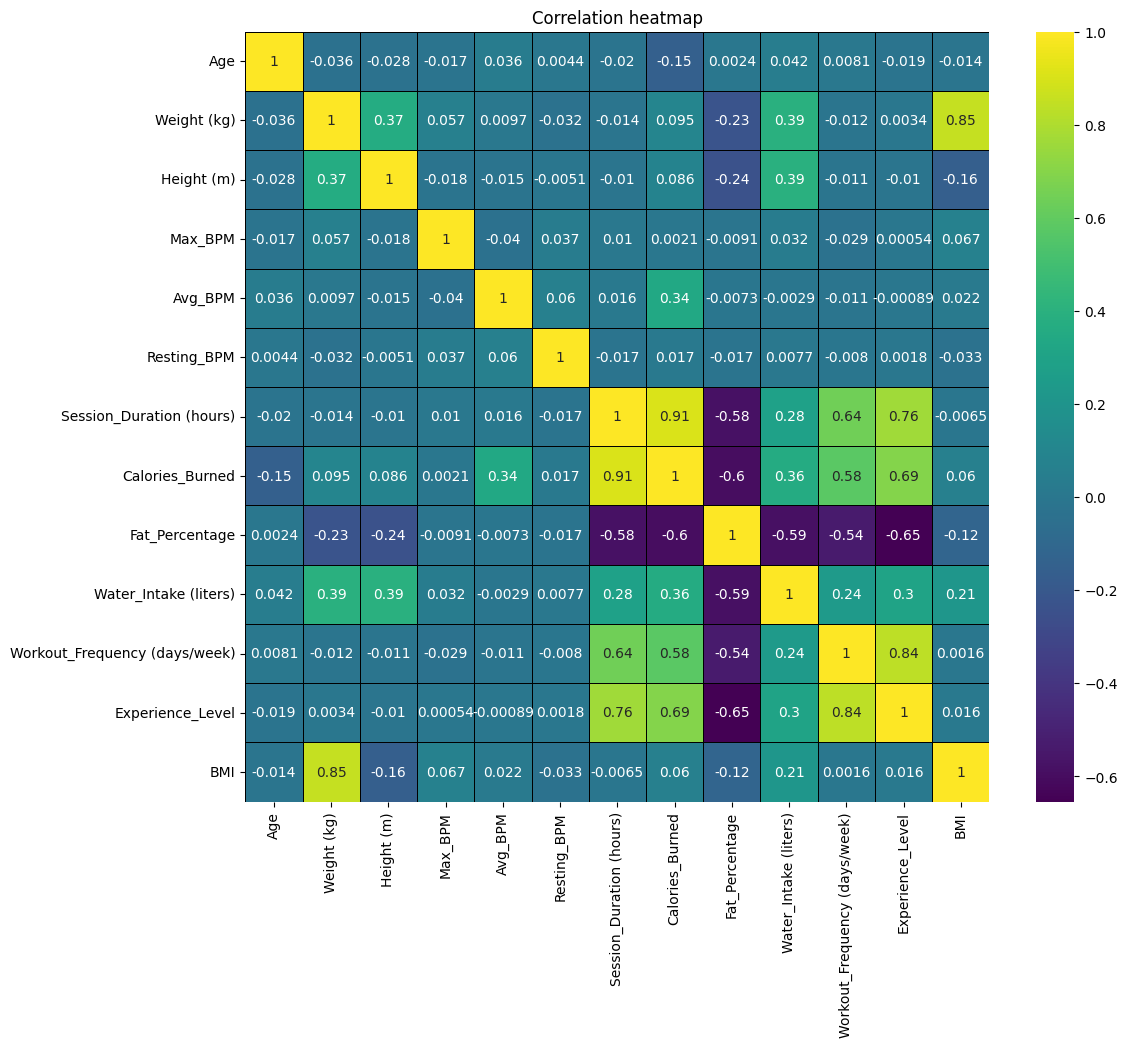

In [11]:
correlation_matrix = dataset.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', linewidth=.5, linecolor='black')
plt.title("Correlation heatmap")
plt.show()

In [12]:
dataset.columns

Index(['Age', 'Gender', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM',
       'Resting_BPM', 'Session_Duration (hours)', 'Calories_Burned',
       'Workout_Type', 'Fat_Percentage', 'Water_Intake (liters)',
       'Workout_Frequency (days/week)', 'Experience_Level', 'BMI'],
      dtype='object')

In [13]:
dataset = remove_outliers(dataset, list(dataset.select_dtypes(include='number').columns))

In [14]:
contigency_table = pd.crosstab(dataset['Age'], dataset['Workout_Type'])

plt.figure(figsize=(8, 8))
sns.heatmap(contigency_table, annot=True, cbar=True)
plt.title("Heatmap of 'Age' vs 'Workout_Type'")
plt.show()

In [15]:
group_of_workout_type = dataset.groupby('Workout_Type')['Age'].mean().reset_index()

sns.set(style='whitegrid', context='talk')
plt.figure(figsize=(8, 6))

bar_plot = sns.barplot(group_of_workout_type, x='Workout_Type', y='Age', palette='viridis', edgecolor='black')

# Adding annotation to bars
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.1f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha = 'center', va = 'center',
                      xytext = (0, 9), 
                      textcoords = 'offset points',
                      fontsize = 12, color = 'black')

plt.xlabel('Workout type',fontsize=12)
plt.ylabel('Age', fontsize=12)
plt.show()

C:\Users\Parth Kachhadiya\AppData\Local\Temp\ipykernel_3092\1545389760.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(group_of_workout_type, x='Workout_Type', y='Age', palette='viridis', edgecolor='black')


In [16]:
sns.scatterplot(dataset, x='Weight (kg)', y='Fat_Percentage', hue='Gender')
plt.show()

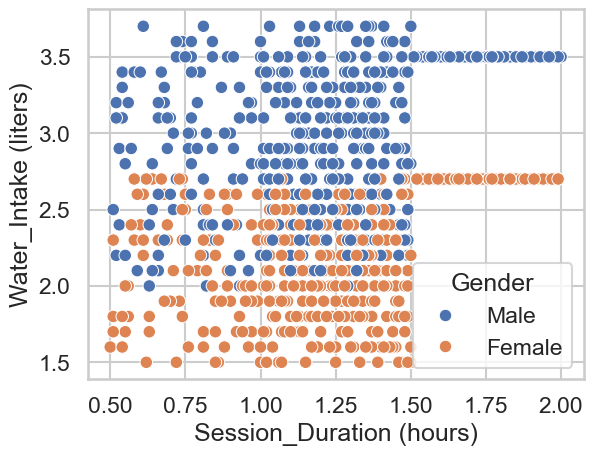

In [17]:
sns.scatterplot(dataset, x='Session_Duration (hours)', y='Water_Intake (liters)', hue='Gender')
plt.show()

C:\Users\Parth Kachhadiya\AppData\Local\Temp\ipykernel_3092\1975829671.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plt = sns.barplot(aged_group, x='Workout_Frequency (days/week)', y='Age',palette='Set2')


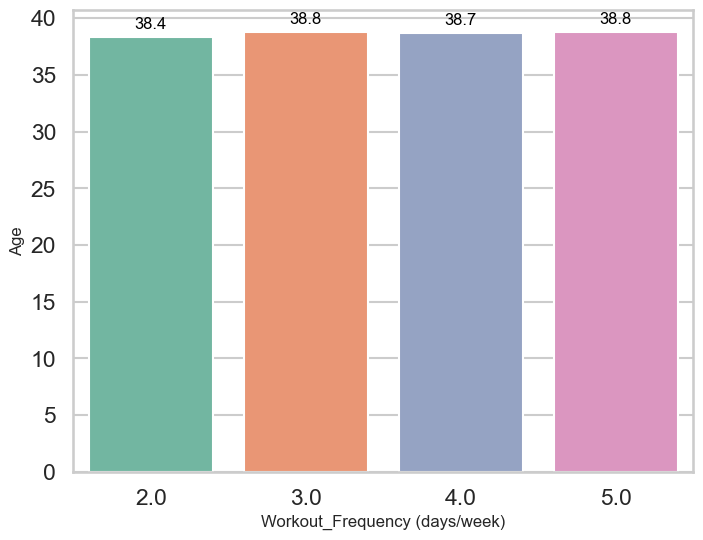

In [18]:
aged_group = dataset.groupby('Workout_Frequency (days/week)')['Age'].mean().reset_index()

sns.set(style='whitegrid', context='talk')
plt.figure(figsize=(8, 6))

bar_plt = sns.barplot(aged_group, x='Workout_Frequency (days/week)', y='Age',palette='Set2')

# Adding annotation to bars
for p in bar_plt.patches:
    bar_plt.annotate(format(p.get_height(), '.1f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha = 'center', va = 'center',
                      xytext = (0, 9), 
                      textcoords = 'offset points',
                      fontsize = 12, color = 'black')

plt.xlabel('Workout_Frequency (days/week)',fontsize=12)
plt.ylabel('Age', fontsize=12)
plt.show()

C:\Users\Parth Kachhadiya\AppData\Local\Temp\ipykernel_3092\2300771965.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(experience_group['Session_Duration (hours)'].median().reset_index(), x='Experience_Level', y='Session_Duration (hours)', palette='muted')


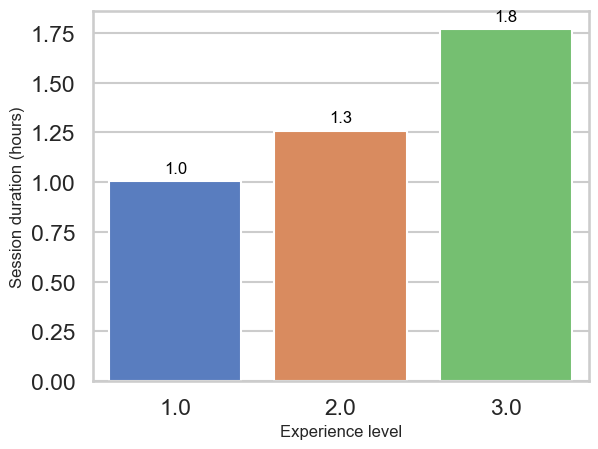

In [19]:
experience_group = dataset.groupby('Experience_Level')
plot = sns.barplot(experience_group['Session_Duration (hours)'].median().reset_index(), x='Experience_Level', y='Session_Duration (hours)', palette='muted')


for p in plot.patches:
    plot.annotate(format(p.get_height(), '.1f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha = 'center', va = 'center',
                      xytext = (0, 9), 
                      textcoords = 'offset points',
                      fontsize = 12, color = 'black')

plt.xlabel('Experience level',fontsize=12)
plt.ylabel('Session duration (hours)', fontsize=12)
plt.show()

In [20]:
print(dataset['Experience_Level'].value_counts())

Experience_Level
2.0    406
1.0    376
3.0    191
Name: count, dtype: int64


C:\Users\Parth Kachhadiya\AppData\Local\Temp\ipykernel_3092\3222924219.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(dataset, x='Experience_Level', palette='cool')


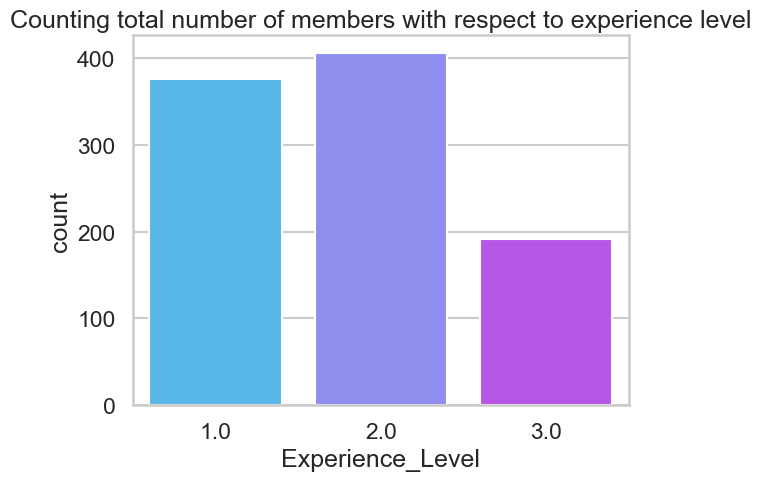

In [21]:
sns.countplot(dataset, x='Experience_Level', palette='cool')
plt.title("Counting total number of members with respect to experience level")
plt.show()

In [22]:
dataset.columns

Index(['Age', 'Gender', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM',
       'Resting_BPM', 'Session_Duration (hours)', 'Calories_Burned',
       'Workout_Type', 'Fat_Percentage', 'Water_Intake (liters)',
       'Workout_Frequency (days/week)', 'Experience_Level', 'BMI'],
      dtype='object')

In [23]:
a = experience_group['Max_BPM'].mean().reset_index()
b = experience_group['Avg_BPM'].mean().reset_index()

fig, axes = plt.subplots(1,2, figsize=(12, 6))

sns.barplot(a, x='Experience_Level', y='Max_BPM', palette='cool', ax=axes[0])
axes[0].set_title("Mean of Max_BPM based on experience level")

sns.barplot(b, x='Experience_Level', y='Avg_BPM', palette='cool', ax=axes[1])
axes[1].set_title("Mean of Avg_BPM based on experience level")

plt.tight_layout()
plt.show()

C:\Users\Parth Kachhadiya\AppData\Local\Temp\ipykernel_3092\981468803.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(a, x='Experience_Level', y='Max_BPM', palette='cool', ax=axes[0])
C:\Users\Parth Kachhadiya\AppData\Local\Temp\ipykernel_3092\981468803.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(b, x='Experience_Level', y='Avg_BPM', palette='cool', ax=axes[1])


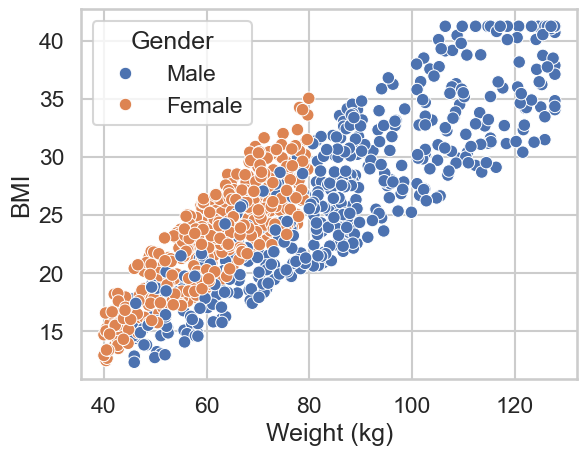

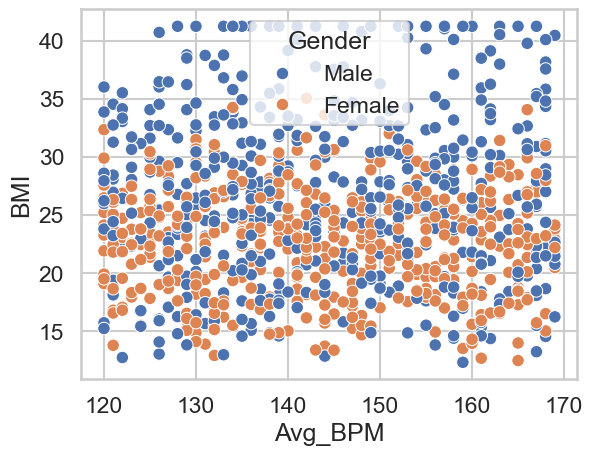

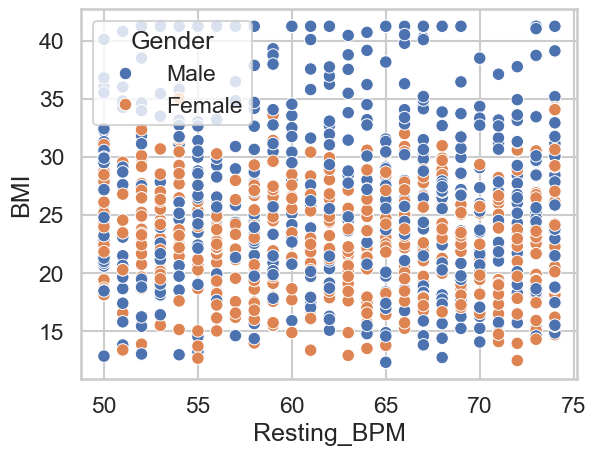

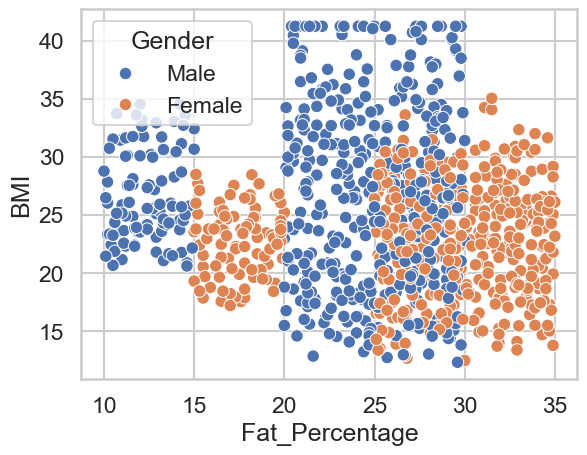

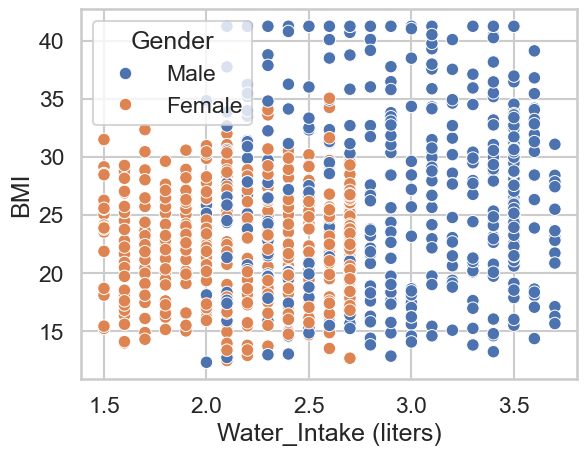

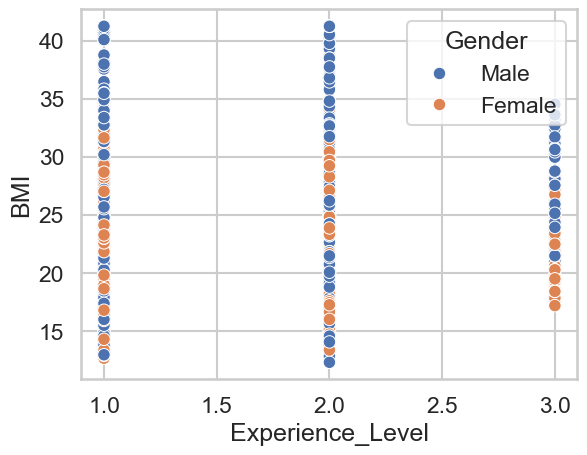

In [24]:
for cols in dataset.select_dtypes(include='number').columns:
    sns.scatterplot(dataset, x=cols, y='BMI', hue='Gender')
    plt.show()

In [25]:
bmi_workout_freq_group = dataset.groupby("Workout_Frequency (days/week)")['BMI'].mean().reset_index()
print(bmi_workout_freq_group)

sns.set(style='whitegrid', context='talk')
plt.figure(figsize=(8, 6))

bar__plt = sns.barplot(bmi_workout_freq_group, x='Workout_Frequency (days/week)', y='BMI',palette='Set2')

# Adding annotation to bars
for p in bar__plt.patches:
    bar__plt.annotate(format(p.get_height(), '.2f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha = 'center', va = 'center',
                      xytext = (0, 9), 
                      textcoords = 'offset points',
                      fontsize = 12, color = 'black')

plt.xlabel('Workout_Frequency (days/week)',fontsize=12)
plt.ylabel('BMI', fontsize=12)
plt.show()

   Workout_Frequency (days/week)        BMI
0                            2.0  24.937792
1                            3.0  24.586535
2                            4.0  25.134428
3                            5.0  24.542941


C:\Users\Parth Kachhadiya\AppData\Local\Temp\ipykernel_3092\2796467118.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar__plt = sns.barplot(bmi_workout_freq_group, x='Workout_Frequency (days/week)', y='BMI',palette='Set2')


   Experience_Level        BMI
0               1.0  24.559681
1               2.0  25.108067
2               3.0  24.747592


C:\Users\Parth Kachhadiya\AppData\Local\Temp\ipykernel_3092\765309209.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar___plt = sns.barplot(exp_level_bmi_group , x='Experience_Level', y='BMI',palette='Set2')


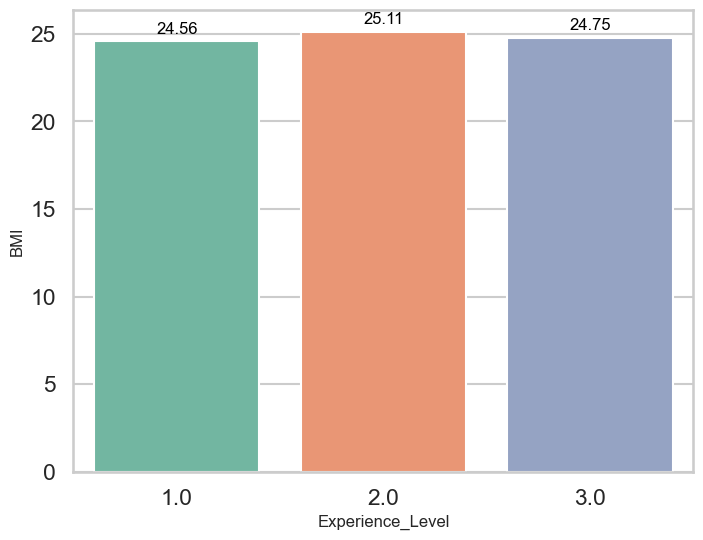

In [26]:
exp_level_bmi_group = dataset.groupby('Experience_Level')['BMI'].mean().reset_index()

print(exp_level_bmi_group)

sns.set(style='whitegrid', context='talk')
plt.figure(figsize=(8, 6))

bar___plt = sns.barplot(exp_level_bmi_group , x='Experience_Level', y='BMI',palette='Set2')

# Adding annotation to bars
for p in bar___plt.patches:
    bar___plt.annotate(format(p.get_height(), '.2f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha = 'center', va = 'center',
                      xytext = (0, 9), 
                      textcoords = 'offset points',
                      fontsize = 12, color = 'black')

plt.xlabel('Experience_Level',fontsize=12)
plt.ylabel('BMI', fontsize=12)
plt.show()

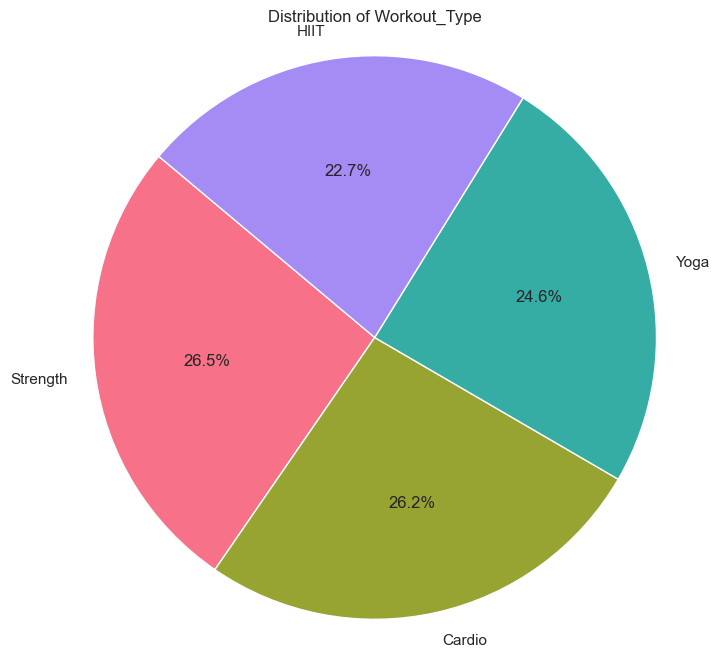

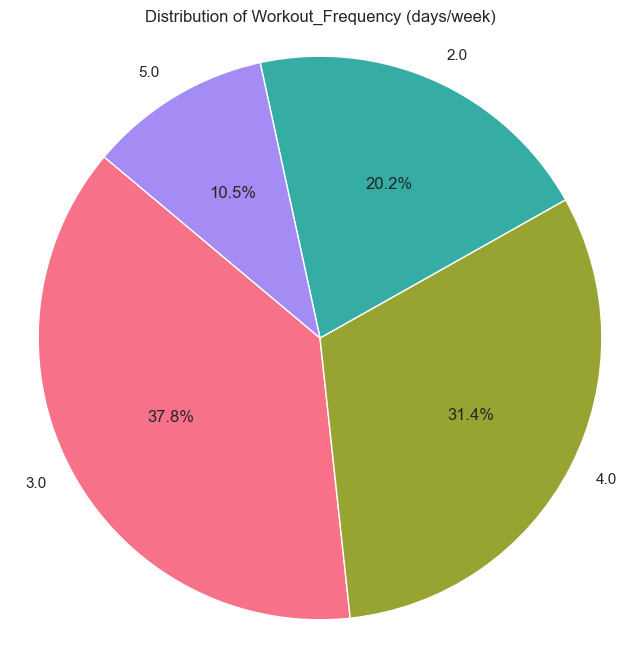

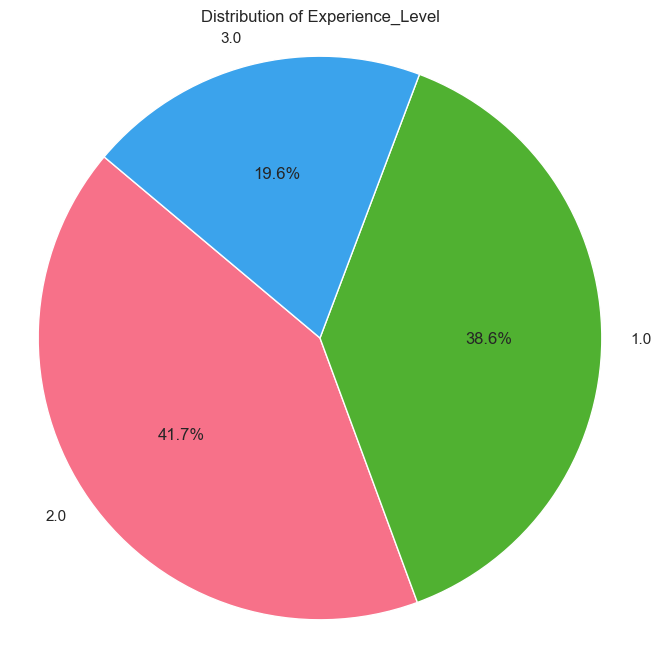

In [27]:
sns.set(style="whitegrid")

for cols in ['Gender', 'Workout_Type', 'Workout_Frequency (days/week)', 'Experience_Level']:
    create_pie_chart(dataset, cols)

In [48]:
# Remoing outliers
dataset = remove_outliers(dataset, list(dataset.select_dtypes(include='number').columns))

C:\Users\Parth Kachhadiya\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


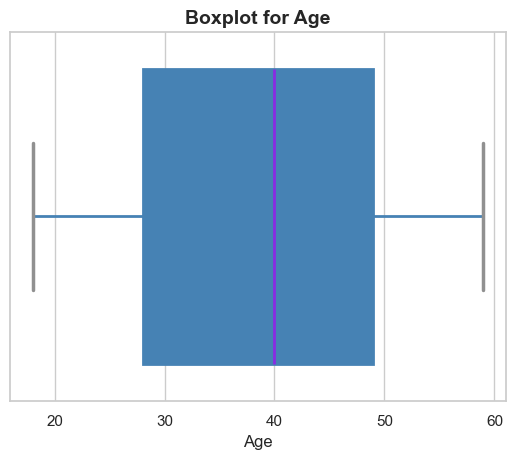

C:\Users\Parth Kachhadiya\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


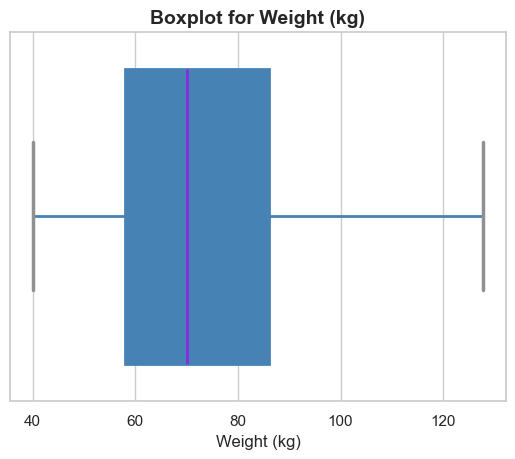

C:\Users\Parth Kachhadiya\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


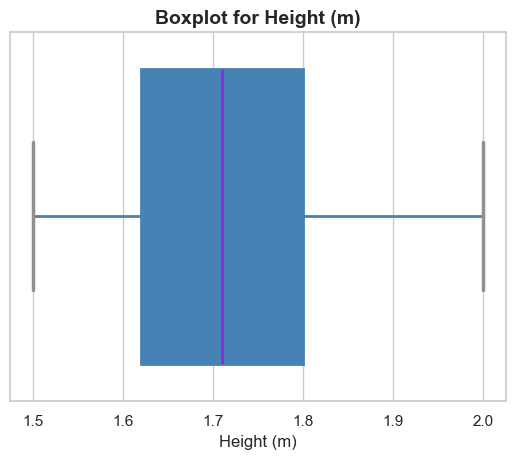

C:\Users\Parth Kachhadiya\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


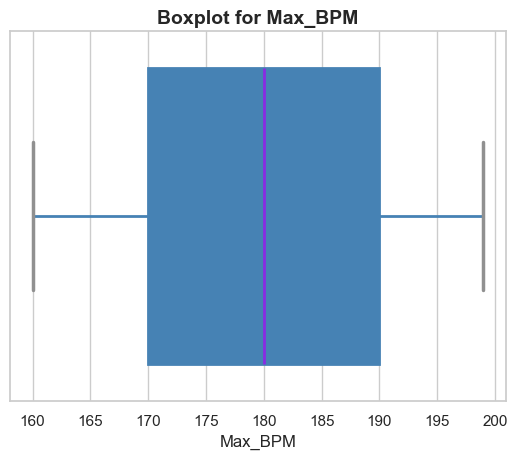

C:\Users\Parth Kachhadiya\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


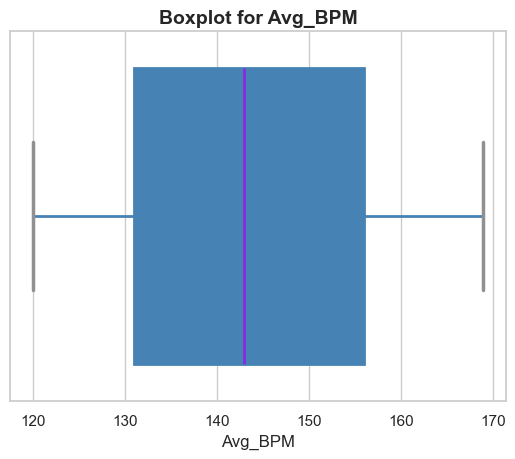

C:\Users\Parth Kachhadiya\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


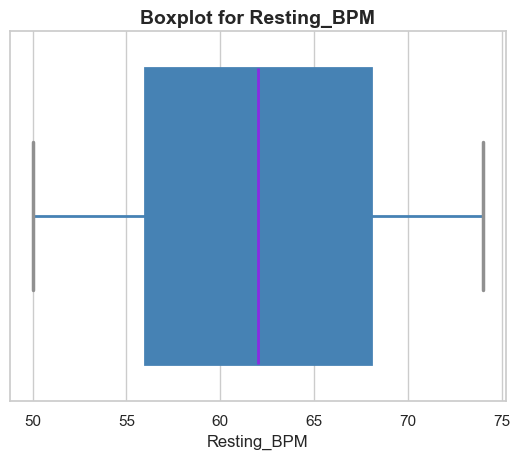

C:\Users\Parth Kachhadiya\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


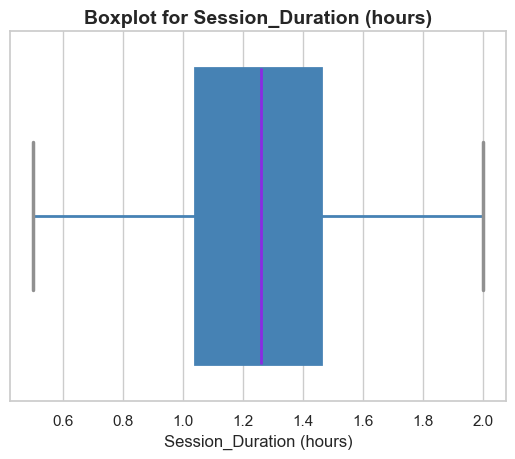

C:\Users\Parth Kachhadiya\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


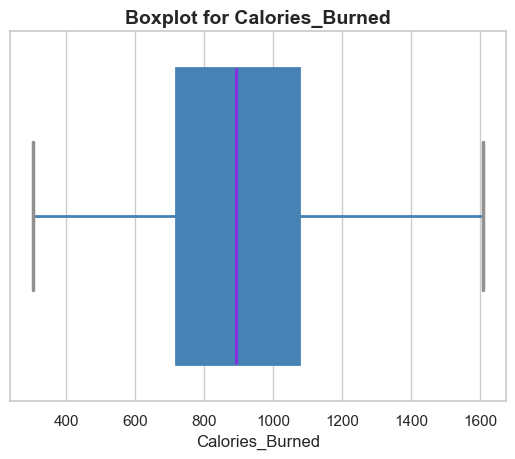

C:\Users\Parth Kachhadiya\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


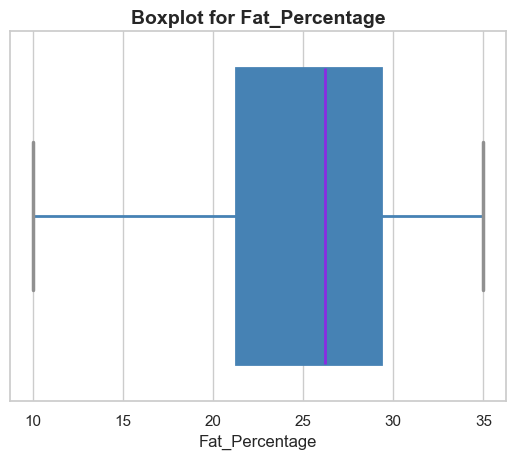

C:\Users\Parth Kachhadiya\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


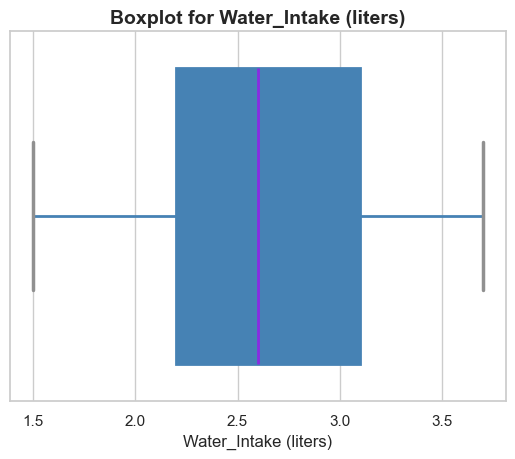

C:\Users\Parth Kachhadiya\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


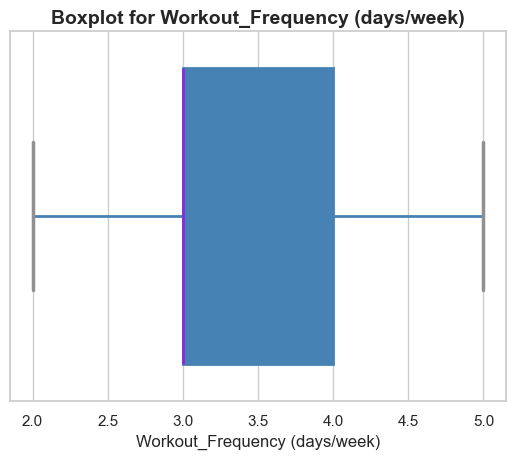

C:\Users\Parth Kachhadiya\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


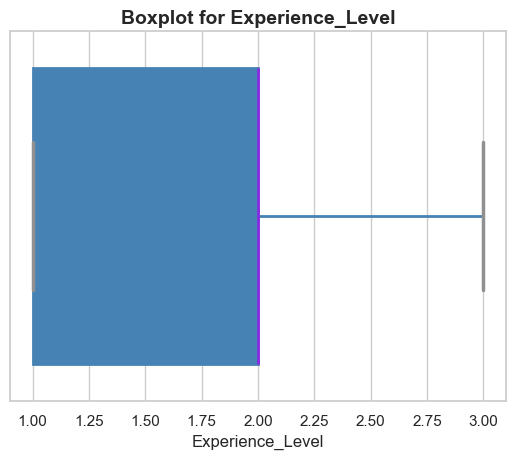

C:\Users\Parth Kachhadiya\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


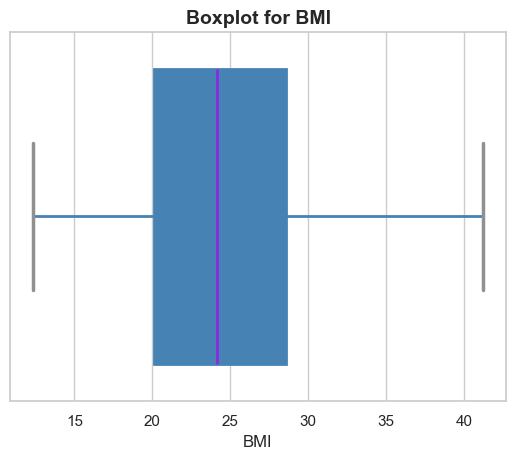

In [67]:
# Analyzing boxplot after removing outliers

for cols in dataset.select_dtypes(include='number').columns:
    sns.boxplot(dataset, x=cols, color='lightcyan', linewidth=2.5, fliersize=8,
                whiskerprops=dict(color='steelblue', linewidth=2),
                boxprops=dict(facecolor='aliceblue', color='steelblue', linewidth=2),
                medianprops=dict(color='blueviolet', linewidth=2),
                flierprops=dict(marker='o', markerfacecolor='orchid', markersize=10, linestyle='none'))
    plt.title(f"Boxplot for {cols}", fontsize=14, weight='bold')
    plt.show()

In [50]:
X = dataset.iloc[:,:-1].values

In [51]:
Y = dataset.iloc[:,-1].values

In [52]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=42)

In [53]:
dataset

Age  Gender  Weight (kg)  Height (m)  Max_BPM  Avg_BPM  Resting_BPM  \
0    56.0    Male         88.3        1.71    180.0    157.0         60.0   
1    46.0  Female         74.9        1.53    179.0    151.0         66.0   
2    32.0  Female         68.1        1.66    167.0    122.0         54.0   
3    25.0    Male         53.2        1.70    190.0    164.0         56.0   
4    38.0    Male         46.1        1.79    188.0    158.0         68.0   
..    ...     ...          ...         ...      ...      ...          ...   
968  24.0    Male         87.1        1.74    187.0    158.0         67.0   
969  25.0    Male         66.6        1.61    184.0    166.0         56.0   
970  59.0  Female         60.4        1.76    194.0    120.0         53.0   
971  32.0    Male        126.4        1.83    198.0    146.0         62.0   
972  46.0    Male         88.7        1.63    166.0    146.0         66.0   

     Session_Duration (hours)  Calories_Burned Workout_Type  Fat_Percentage  \
0                        1.69           1313.0         Yoga            12.6   
1                        1.30            883.0         HIIT            33.9   
2                        1.11            677.0       Cardio            33.4   
3                        0.59            532.0     Strength            28.8   
4                        0.64            556.0     Strength            29.2   
..                        ...              ...          ...             ...   
968                      1.57           1364.0     Strength            10.0   
969                      1.38           1260.0     Strength            25.0   
970                      1.72            929.0       Cardio            18.8   
971                      1.10            883.0         HIIT            28.2   
972                      0.75            542.0     Strength            28.8   

     Water_Intake (liters)  Workout_Frequency (days/week)  Experience_Level  \
0                      3.5                            4.0               3.0   
1                      2.1                            4.0               2.0   
2                      2.3                            4.0               2.0   
3                      2.1                            3.0               1.0   
4                      2.8                            3.0               1.0   
..                     ...                            ...               ...   
968                    3.5                            4.0               3.0   
969                    3.0                            2.0               1.0   
970                    2.7                            5.0               3.0   
971                    2.1                            3.0               2.0   
972                    3.5                            2.0               1.0   

       BMI  
0    30.20  
1    32.00  
2    24.71  
3    18.41  
4    14.39  
..     ...  
968  28.77  
969  25.69  
970  19.50  
971  37.74  
972  33.38  

[973 rows x 15 columns]

In [54]:
transformer = ColumnTransformer(
    [
        ("Categorical_transformation", OneHotEncoder(drop='first', handle_unknown='ignore'), [1, 9, 12, 13]),
        ("Scalling", StandardScaler(), [0, 2, 3, 4, 5, 6, 7, 8, 10, 11])
    ],
    remainder='passthrough'
)

In [55]:
transformer.fit(x_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('Categorical_transformation',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 [1, 9, 12, 13]),
                                ('Scalling', StandardScaler(),
                                 [0, 2, 3, 4, 5, 6, 7, 8, 10, 11])])

In [56]:
x_train = transformer.transform(x_train)
x_test = transformer.transform(x_test)

In [57]:
# Models

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [58]:
# Testing processed data on 'LinearRegression' Model

model_a = LinearRegression()

model_a.fit(x_train, y_train)
y_hat = model_a.predict(x_test)

print(f"Mean absolute error: {mean_absolute_error(y_test, y_hat)}")
print(f"R2-score: {r2_score(y_test, y_hat)}")

print(model_a.coef_)
print(model_a.intercept_)

Mean absolute error: 0.5860399565694403
R2-score: 0.9859562667543464
[ 0.4392479  -0.12240979 -0.01752108 -0.10449612  0.09683992  0.13360767
  0.05878731 -0.02202395  0.29239965  0.09308778  6.58211107 -3.58272682
  0.02616854 -0.13758067 -0.01335366 -0.28731146  0.32569816  0.08928952
  0.01258101]
24.35434035447693


In [59]:
# Testing processed data on 'Ridge' Model

model_b = Ridge()

parameters = {'alpha' : [.1,.2,.3,.4,.5,.6,.7,.8,.9,1,2,3,4,5,6,7,8,9,10]}

cross_validation = GridSearchCV(estimator=model_b,
                               param_grid=parameters,
                               scoring='neg_mean_squared_error',
                               cv=5)

cross_validation.fit(x_train, y_train)
y_hat = cross_validation.predict(x_test)

print(f"Mean absolute error: {mean_absolute_error(y_test, y_hat)}")
print(f"R2-score: {r2_score(y_test, y_hat)}")

print(cross_validation.best_params_)
print(cross_validation.best_score_)

Mean absolute error: 0.591374504471784
R2-score: 0.9857528218981155
{'alpha': 2}
-0.6556713706296693


In [60]:
# Testing processed data on 'Lasso' model

model_c = Lasso()

parameters = {'alpha' : [.1,.2,.3,.4,.5,.6,.7,.8,.9,1,2,3,4,5,6,7,8,9,10]}

cross__validation = GridSearchCV(estimator=model_c,
                               param_grid=parameters,
                               scoring='neg_mean_squared_error',
                               cv=5)

cross__validation.fit(x_train, y_train)
y__hat = cross__validation.predict(x_test)

print(f"Mean absolute error: {mean_absolute_error(y_test, y__hat)}")
print(f"R2-score: {r2_score(y_test, y__hat)}")

print(cross_validation.best_params_)
print(cross_validation.best_score_)

Mean absolute error: 0.6289941429094716
R2-score: 0.9836441004672953
{'alpha': 2}
-0.6556713706296693


In [61]:
# Testing processed data on 'DecisionTreeRegressor' model

model_d = DecisionTreeRegressor()

model_d.fit(x_train, y_train)
y___hat = model_d.predict(x_test)

print(f"Mean absolute error: {mean_absolute_error(y___hat, y_test)}")
print(f"R2-score: {r2_score(y___hat, y_test)}")

Mean absolute error: 0.6910769230769229
R2-score: 0.9784509054810931


In [65]:
# Testing processed data on 'RandomForestRegressor' model

model_e = RandomForestRegressor(
    n_estimators = 1, 
)

model_e.fit(x_train, y_train)
Y_hat = model_e.predict(x_test)

print(f"Mean absolute error: {mean_absolute_error(Y_hat, y_test)}")
print(f"R2-score: {r2_score(Y_hat, y_test)}")

Mean absolute error: 0.8795897435897437
R2-score: 0.964302821549323
